In [55]:
from typing import Any, Optional, List

import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent, PositionsTracker
from qubx.pandaz.utils import *
import qubx.pandaz.ta as pta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal

from qubx.utils.charting.lookinglass import LookingGlass
from qubx import QubxLogConfig
from qubx.backtester import simulate, variate
from qubx.core.metrics import tearsheet, chart_signals, get_symbol_pnls
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer
from qubx.core.metrics import chart_signals
from qubx.trackers.riskctrl import AtrRiskTracker
from qubx.data.helpers import get_candles_df_from_questdb, get_symbols_from_questdb
from qubx.data.helpers import load_data


START = "2024-01-01"
STOP = "2024-05-01"


def __sim(config: dict, reader, symbols: list[str] | None = None, timeframe: str = "1h", fit: str | None = None, start: str = START, stop: str = STOP, silent: bool = True):
    if symbols is None:
        symbols = ["BINANCE.UM:BTCUSDT", "BINANCE.UM:ETHUSDT", "BINANCE.UM:XRPUSDT"]
    return simulate(
        config,
        data=reader,
        capital=10000,
        instruments=symbols,
        subscription=dict(type="ohlc", timeframe=timeframe, nback=0),
        trigger="-1Sec",
        fit=fit,
        commissions="vip0_usdt",
        start=start,
        stop=stop,
        silent=silent
    )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
r = MultiQdbConnector("xlydian-data")

2024-08-12 14:49:59.641 [ 🐞 ] Connected to QuestDB at xlydian-data:8812


## 1.0 Reference experiment with fixed universe

In [21]:
class StrategyForTracking(IStrategy):
    timeframe: str = "1h"
    fast_period = 5
    slow_period = 12
    atr_tp: float | None = None
    atr_sl: float | None = 5

    def on_fit(
        self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None
    ):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return AtrRiskTracker(
            self.atr_tp, self.atr_sl, self.timeframe, 50, atr_smoother="kama", sizer=FixedRiskSizer(0.5)
        )

  0%|          | 0/6 [00:00<?, ?it/s]

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
5,"/SFT_(t=1h,fp=20,sp=100)",1065.884754,0.353935,2.287089,2.779416,5.119566,575.435278,4.872535,7.170813,1.847156,0.803888,108.542898,0.085577,94.125653,107.0
2,"/SFT_(t=1h,fp=10,sp=100)",260.835880,0.080082,0.634960,0.233438,8.520053,921.099981,1.180418,1.108408,1.162739,0.233440,113.981829,0.023605,122.048004,149.0
4,"/SFT_(t=1h,fp=20,sp=50)",-432.151080,-0.123806,-0.936617,-0.415224,9.142085,951.418875,-1.536146,-1.650638,1.111590,0.358936,116.443610,-0.033836,180.002968,225.0
1,"/SFT_(t=1h,fp=10,sp=50)",-946.061776,-0.257209,-2.291145,-1.596941,10.911679,1105.406751,-3.696453,-2.712563,1.040549,0.678857,116.196383,-0.079264,198.911672,252.0
0,"/SFT_(t=1h,fp=10,sp=25)",-1343.263202,-0.350505,-3.405840,-7.141608,14.832914,1498.700061,-5.206811,-2.538650,0.779367,0.953968,118.254646,-0.116063,313.739202,392.0
3,"/SFT_(t=1h,fp=20,sp=25)",-1916.518138,-0.470882,-5.271725,-8.153070,21.097943,2158.799861,-7.587370,-2.339254,0.774444,0.959648,119.523118,-0.172309,404.167427,512.0


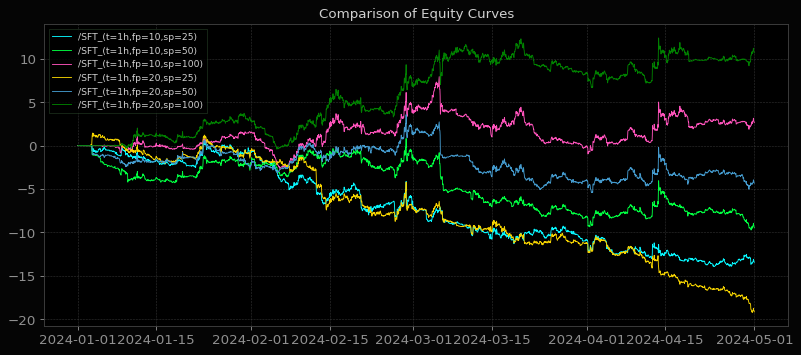

In [30]:
QubxLogConfig.set_log_level("ERROR")

timeframe = "1h"

symbols = ["BTCUSDT", "ETHUSDT", "XRPUSDT"]
exchange = "BINANCE.UM"

instruments = [f"{exchange}:{s}" for s in symbols]

rep = __sim(
    variate(
        StrategyForTracking,
        timeframe=[timeframe],
        fast_period=[10, 20],
        slow_period=[25, 50, 100],
        conditions=lambda fast_period, slow_period: fast_period < slow_period,
    ),
    r,
    symbols=instruments,
)

tearsheet(rep)

In [ ]:
symbol = "BTCUSDT"
start = "2024-01-01"
stop = "2024-05-01"

ohlc = load_data(r, exchange, symbol, start, stop, timeframe=timeframe, transform=AsOhlcvSeries())[symbol]

fast = sma(ohlc.close, 20)
slow = sma(ohlc.close, 100)

chart_signals(rep[5], symbol, ohlc=ohlc, timeframe=timeframe, start=start, end=stop, overlay=[fast.pd(), slow.pd()])

## 2.0 Apply top volume universe filter

In [3]:
db_symbols = get_symbols_from_questdb("BINANCE.UM", r)
print(f"Total symbols: {len(db_symbols)}")

candles = get_candles_df_from_questdb("BINANCE.UM", db_symbols, r, "2024-03-01", "2024-05-01", timeframe="1d")
candles.tail()

Total symbols: 291


trxusdt                                            \
             close   count   high    low   open quote_volume   
timestamp                                                      
2024-04-26   0.120  251959  0.121  0.116  0.117   88569816.0   
2024-04-27   0.120  202257  0.121  0.118  0.120   70132312.0   
2024-04-28   0.121  189817  0.124  0.120  0.120   67039796.0   
2024-04-29   0.119  211153  0.121  0.118  0.121   74154160.0   
2024-04-30   0.120  277532  0.121  0.117  0.119  126262856.0   

                                                                  btcusdt  \
           taker_buy_quote_volume taker_buy_volume        volume    close   
timestamp                                                                   
2024-04-26             44405604.0      374723200.0  7.475364e+08  63748.8   
2024-04-27             34178752.0      285312032.0  5.854977e+08  63421.0   
2024-04-28             35033884.0      289432736.0  5.541937e+08  63088.3   
2024-04-29             35585128.0      298722080.0  6.224472e+08  63842.4   
2024-04-30             61954940.0      520478048.0  1.060715e+09  60651.2   

            ...    rndrusdt zrxusdt                                            \
            ...      volume   close   count   high    low   open quote_volume   
timestamp   ...                                                                 
2024-04-26  ...   9826069.0   0.507  141326  0.520  0.500  0.519   19039140.0   
2024-04-27  ...   8898848.0   0.506  155118  0.516  0.467  0.507   24259850.0   
2024-04-28  ...   7403363.5   0.499  108152  0.521  0.495  0.506   17711534.0   
2024-04-29  ...  10504640.0   0.497  117741  0.508  0.484  0.499   19178606.0   
2024-04-30  ...  14769199.0   0.462  153583  0.503  0.447  0.497   24549138.0   

                                                                
           taker_buy_quote_volume taker_buy_volume      volume  
timestamp                                                       
2024-04-26              9408803.0       18435846.0  37310456.0  
2024-04-27             11378754.0       22884862.0  48814812.0  
2024-04-28              8696211.0       16976444.0  34579820.0  
2024-04-29              9277761.0       18792210.0  38849672.0  
2024-04-30             11759853.0       25190380.0  52598784.0  

[5 rows x 2529 columns]

In [ ]:
symbol = "wifusdt"

LookingGlass(
    candles.loc[:, pd.IndexSlice[symbol,]],
    {
        "volume": ["bar", candles.loc[:, pd.IndexSlice[symbol, "quote_volume"]].rename("volume")],
    }
).look(title=symbol).hover().show()

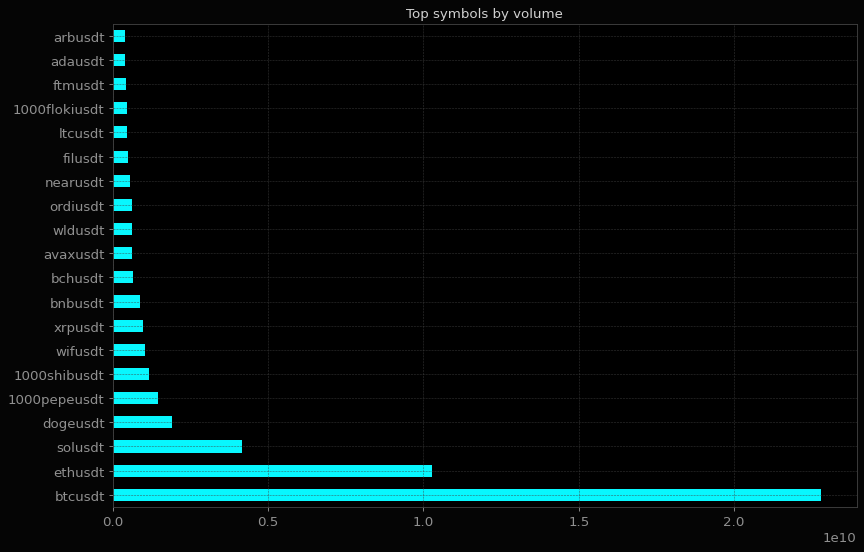

In [5]:
top_100 = candles.swaplevel(axis=1).quote_volume.ffill().dropna(axis=1).mean().sort_values(ascending=False).head(100)
top_100[:20].plot(
    kind="barh", figsize=(12, 8), title="Top symbols by volume"
);

In [51]:
from qubx.data.helpers import get_candles_df_from_questdb

EXCHANGE = "BINANCE.UM"
UNIVERSE = list(top_100.index)

class CrossingsWithUniverseV2(IStrategy):
    timeframe: str = "1h"
    fast_period = 5
    slow_period = 12
    atr_tp: float | None = None
    atr_sl: float | None = 5

    universe_lookback: str = "30d"
    universe_size: int = 10

    def on_fit(
        self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None
    ):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")
        fit_time = pd.Timestamp(fit_time)
        _start = fit_time - pd.Timedelta(self.universe_lookback)

        candles = get_candles_df_from_questdb(EXCHANGE, UNIVERSE, r, _start, fit_time, timeframe="1d")
        volume = candles.swaplevel(axis=1).quote_volume.ffill().dropna(axis=1) # type: ignore
        symbols = volume.mean().sort_values(ascending=False).head(self.universe_size)
        _symbols = list(symbols.index)
        # remove if 1000 in name
        _symbols = [s for s in _symbols if "1000" not in s]

        logger.info(f" -> Universe: {_symbols}")

        instruments = [lookup.find_symbol(EXCHANGE, symbol.upper()) for symbol in _symbols]
        instruments = [i for i in instruments if i is not None]

        ctx.set_universe(instruments)

    def on_universe_change(
        self, ctx: StrategyContext, add_instruments: list[Instrument], rm_instruments: list[Instrument]
    ) -> None:
        add_symbols = [i.symbol for i in add_instruments]
        rm_symbols = [i.symbol for i in rm_instruments]
        logger.info(f" -> Universe change: \n\tadd=<green>{add_symbols}</green>, rm=<red>{rm_symbols}</red>")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)

            if len(fast) < 2 or len(slow) < 2:
                continue

            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return AtrRiskTracker(
            self.atr_tp, self.atr_sl, self.timeframe, 50, atr_smoother="kama", sizer=FixedRiskSizer(0.5)
        )

In [52]:
QubxLogConfig.set_log_level("INFO")

timeframe = "1h"

symbols = ["BTCUSDT"]
exchange = "BINANCE.UM"

instruments = [f"{exchange}:{s}" for s in symbols]

rep3 = __sim(
    variate(
        CrossingsWithUniverseV2,
        timeframe=[timeframe],
        fast_period=[20],
        slow_period=[100],
    ),
    r,
    symbols=instruments,
    # create cron expression for monthly rebalancing
    fit="@monthly"
)

2024-08-12 15:13:06.441 [ ℹ️ ] CrossingsWithUniverseV2 new parameters:
	set timeframe <- 1h
	set fast_period <- 20
	set slow_period <- 100
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedData.binance.um initialized
2024-01-01 00:00:00.000 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1h', 'nback': 0} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ ℹ️ ] Initializing chunks for each loader
2024-01-01 00:00:00.001 [ ℹ️ ]  -> Fit is called | fit_time: 2023-12-01 00:00:00 / prev: None
2024-01-01 00:00:00.001 [ ℹ️ ]  -> Universe: ['btcusdt', 'ethusdt', 'solusdt', 'xrpusdt', 'dogeusdt', 'linkusdt', 'avaxusdt', 'tiausdt', 'trbusdt', 'maticusdt']
2024-01-01 00:00:00.001 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1h', 'nback': 0} for 
	['TIAUSDT', 'DOGEUSDT', 'TRBUSDT', 'SOLUSDT', 'AVAXUSDT', 'MATICUSDT', 'ETHUSDT', 'LINKUSDT', 'XRPUSDT'] 
2024-01-01 

In [54]:
tearsheet(rep3)

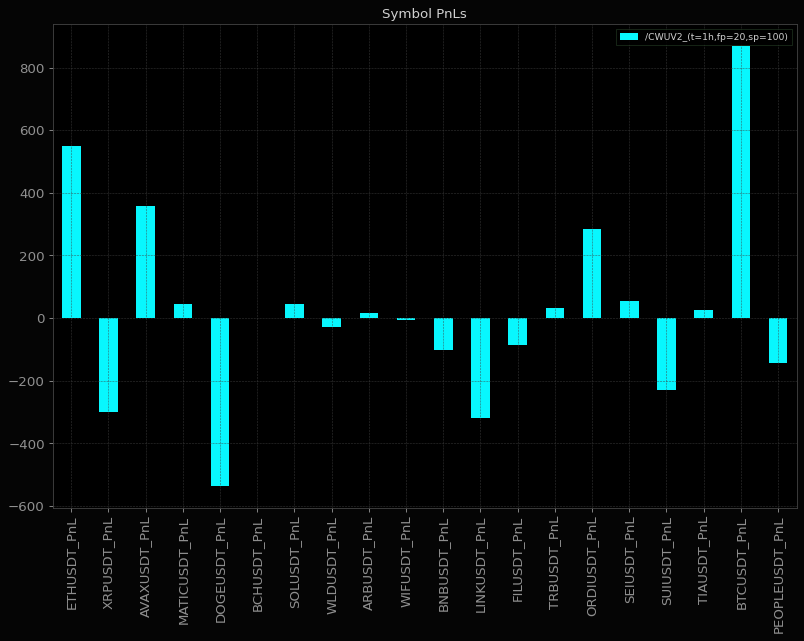

In [58]:
get_symbol_pnls(rep3).T.plot(kind="bar", figsize=(12, 8), title="Symbol PnLs");

In [66]:
rep3[0].signals_log.groupby("instrument_id").signal.count().sort_values(ascending=False)

instrument_id
XRPUSDT       42
DOGEUSDT      39
ETHUSDT       35
SOLUSDT       35
BTCUSDT       30
SUIUSDT       23
AVAXUSDT      19
LINKUSDT      19
ORDIUSDT      15
BNBUSDT       12
PEOPLEUSDT    11
WLDUSDT       11
FILUSDT       10
TIAUSDT        9
ARBUSDT        9
SEIUSDT        8
WIFUSDT        8
MATICUSDT      7
TRBUSDT        5
Name: signal, dtype: int64

In [ ]:
symbol = "TRBUSDT"
start = "2024-01-01"
stop = "2024-05-01"

ohlc = load_data(r, exchange, symbol, start, stop, timeframe=timeframe, transform=AsOhlcvSeries())[symbol]

fast = sma(ohlc.close, 20)
slow = sma(ohlc.close, 100)

chart_signals(rep3[0], symbol, ohlc=ohlc, timeframe=timeframe, start=start, end=stop, overlay=[fast.pd(), slow.pd()])

In [41]:
from qubx.data.helpers import load_data

symbol = "WIFUSDT"
start = "2024-01-01"
stop = "2024-05-01"

look_symbols = ['1000SHIBUSDT', 'WIFUSDT', 'AVAXUSDT', '1000PEPEUSDT', 'BNBUSDT']

ohlc = load_data(r, exchange, look_symbols, start, stop, timeframe=timeframe, transform=AsPandasFrame())

# LookingGlass(ohlc).look(title=symbol).hover().show()
ohlc.keys()

dict_keys(['1000SHIBUSDT', 'WIFUSDT', 'AVAXUSDT', '1000PEPEUSDT', 'BNBUSDT'])

<Axes: title={'center': 'Close prices'}, xlabel='timestamp'>

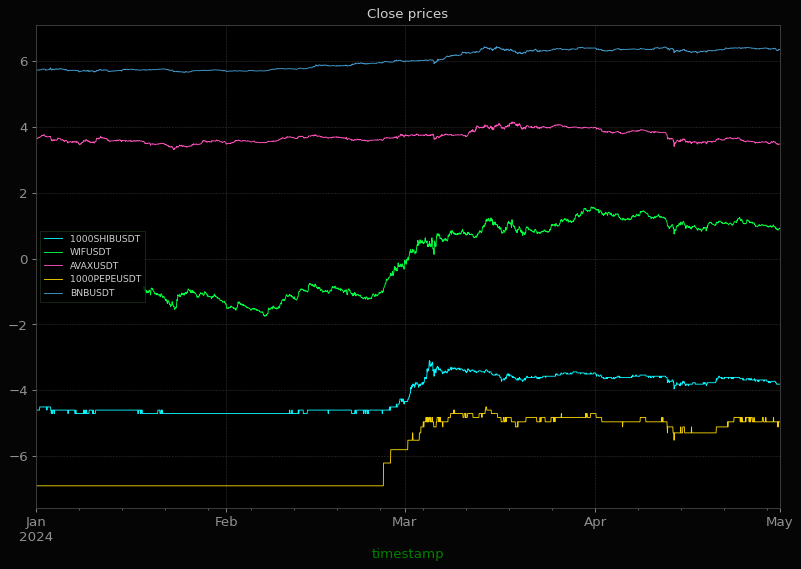

In [44]:
pd.concat([ohlc[symbol].close.rename(symbol) for symbol in look_symbols], axis=1).pipe(np.log).plot(figsize=(12, 8), title="Close prices")

In [50]:
symbol = "1000SHIBUSDT"
LookingGlass(ohlc[symbol]).look(title=symbol).hover().show()

In [49]:
ohlc[symbol].close

timestamp
2024-01-01 00:00:00    0.001
2024-01-01 01:00:00    0.001
2024-01-01 02:00:00    0.001
2024-01-01 03:00:00    0.001
2024-01-01 04:00:00    0.001
                       ...  
2024-04-30 20:00:00    0.007
2024-04-30 21:00:00    0.007
2024-04-30 22:00:00    0.007
2024-04-30 23:00:00    0.007
2024-05-01 00:00:00    0.007
Name: close, Length: 2905, dtype: float64